<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/main/Pinn_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

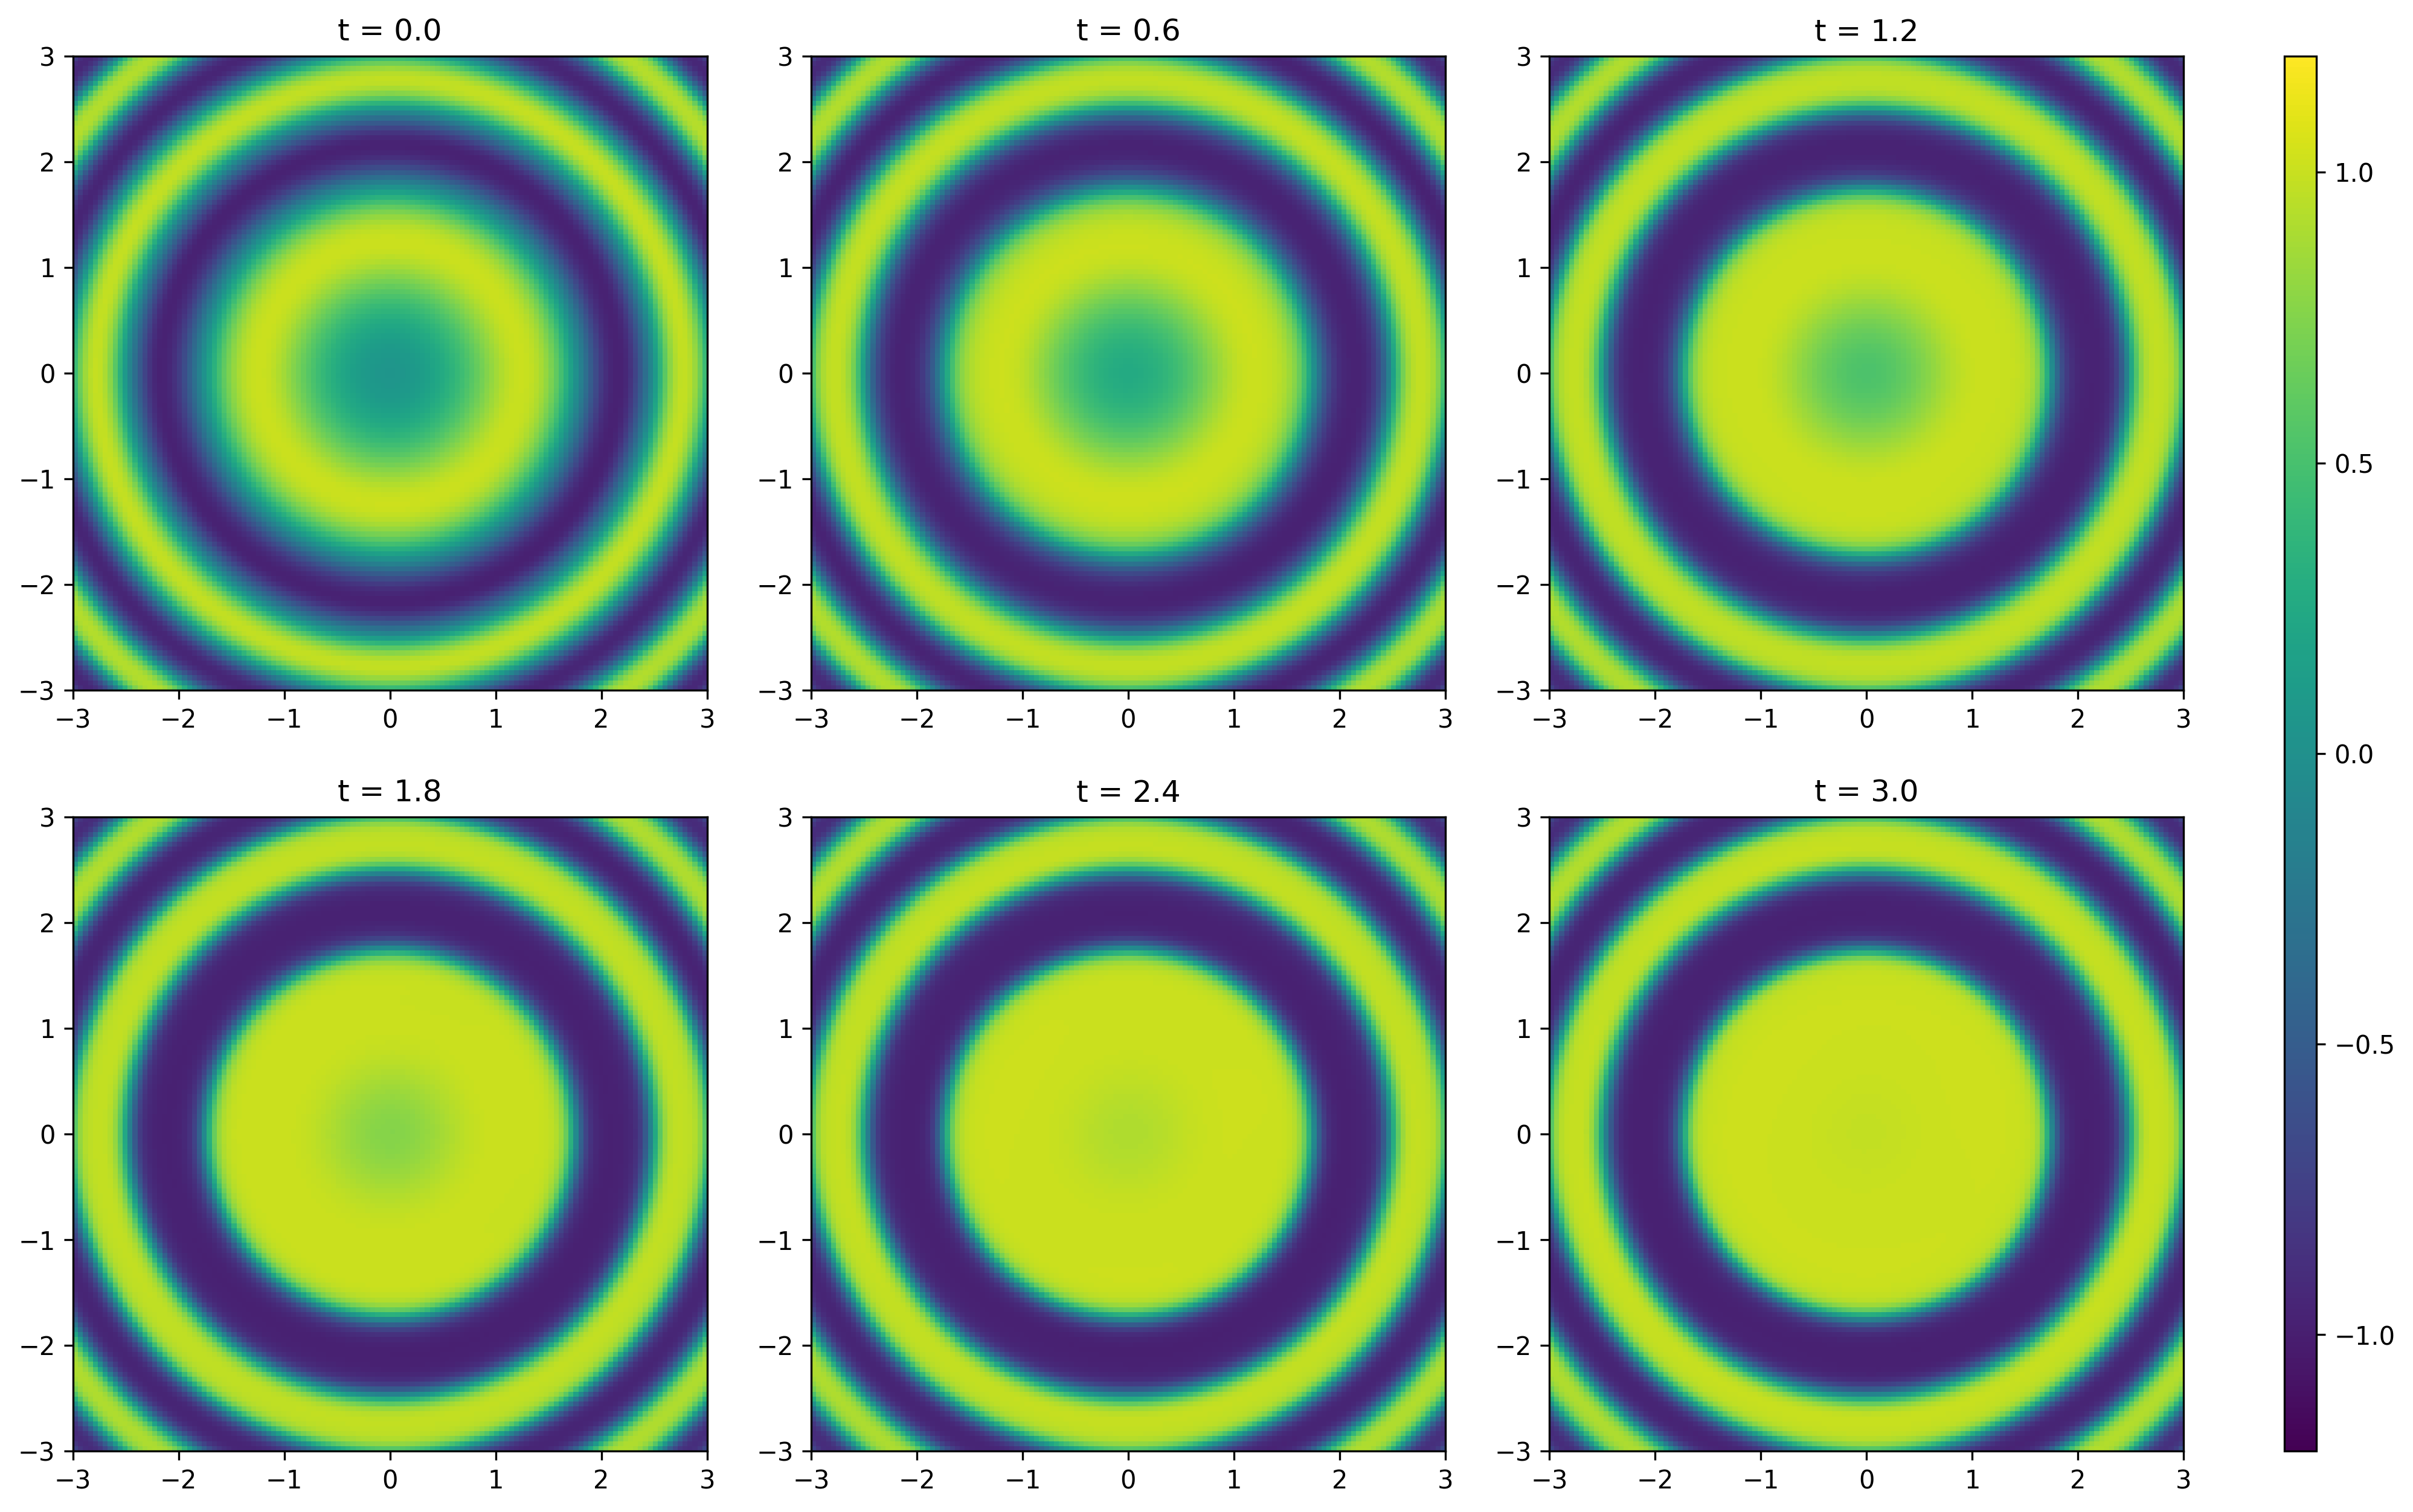

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.autograd import grad
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

dev = torch . device ("cuda:0" if torch . cuda . is_available () else
          "cpu")

T = 3.0 # the time horizom
M = 20000 # the number of training samples

torch . manual_seed (0)

x_data = torch . randn (M, 2).to(dev ) * 2
t_data = torch . rand (M, 1).to(dev) * T

def phi(x):
  return x. square ().sum ( axis =1, keepdims = True ). sin ()

# We use a network with 4 hidden layers of 50 neurons each and the
# Swish activation function ( called SiLU in PyTorch )
N = torch .nn. Sequential (
  torch .nn. Linear (3, 50) , torch .nn. SiLU () ,
  torch .nn. Linear (50 , 50) , torch .nn. SiLU () ,
  torch .nn. Linear (50 , 50) , torch .nn. SiLU () ,
  torch .nn. Linear (50 , 50) , torch .nn. SiLU () ,
  torch .nn. Linear (50 , 1) ,
).to(dev )

optimizer = torch.optim.Adam(N.parameters(), lr=3e-4)
J = 256 # the batch size

for i in range (20000) :
  # Choose a random batch of training samples
  indices = torch . randint (0, M, (J ,))
  x = x_data [ indices , :]
  t = t_data [ indices , :]

  x1 , x2 = x[:, 0:1] , x[:, 1:2]

  x1. requires_grad_ ()
  x2. requires_grad_ ()
  t. requires_grad_ ()

  optimizer . zero_grad ()

  # Denoting by u the realization function of the ANN , compute
  # u(0, x) for each x in the batch
  u0 = N( torch . hstack (( torch . zeros_like (t), x)))
  # Compute the loss for the initial condition
  initial_loss = (u0 - phi(x)). square (). mean ()

  # Compute the partial derivatives using automatic
  # differentiation
  u = N( torch . hstack ((t, x1 , x2)))
  ones = torch . ones_like (u)
  u_t = grad (u, t, ones , create_graph = True ) [0]
  u_x1 = grad (u, x1 , ones , create_graph = True )[0]
  u_x2 = grad (u, x2 , ones , create_graph = True )[0]
  ones = torch . ones_like ( u_x1 )
  u_x1x1 = grad (u_x1 , x1 , ones , create_graph = True )[0]
  u_x2x2 = grad (u_x2 , x2 , ones , create_graph = True )[0]

  # Compute the loss for the PDE
  Laplace = u_x1x1 + u_x2x2
  pde_loss = ( u_t - (0.005 * Laplace + u - u **3) ). square (). mean ()

  # Compute the total loss and perform a gradient step
  loss = initial_loss + pde_loss
  loss . backward ()
  optimizer . step ()

### Plot the solution at different times

mesh = 128
a, b = -3, 3

gs = GridSpec (2, 4, width_ratios =[1 , 1, 1, 0.05])
fig = plt. figure ( figsize =(16 , 10) , dpi =300)
x, y = torch . meshgrid (
  torch . linspace (a, b, mesh ),
  torch . linspace (a, b, mesh ),
  indexing ="xy"
)
x = x. reshape (( mesh * mesh , 1)).to(dev)
y = y. reshape (( mesh * mesh , 1)).to(dev)

for i in range (6):
  t = torch . full (( mesh * mesh , 1) , i * T / 5).to(dev)
  z = N( torch .cat ((t, x, y), 1))
  z = z. detach ().cpu (). numpy (). reshape (( mesh , mesh ))

  ax = fig. add_subplot (gs[i // 3, i % 3])
  ax. set_title (f"t = {i * T / 5}")
  ax. imshow (
    z, cmap ="viridis", extent =[a, b, a, b], vmin = -1.2 , vmax =1.2
  )

  # Add the colorbar to the figure
norm = plt. Normalize ( vmin = -1.2 , vmax =1.2)
# Add the colorbar to the figure
norm = plt.Normalize(vmin=-1.2, vmax=1.2)
sm = ScalarMappable(cmap="viridis", norm=norm)
cax = fig.add_subplot(gs[:, 3])
fig.colorbar(sm, cax=cax, orientation='vertical')

# fig.savefig("../plots/pinn.pdf", bbox_inches="tight")